
# GDP Time Series Analysis and Forecasting

### Introduction

Economic forecasting plays a crucial role in understanding and predicting the future trajectory of a country's economy. Among the key indicators of economic health, **Gross Domestic Product (GDP)** is one of the most widely used metrics to assess the overall economic activity within a nation. Accurate forecasting of GDP is essential for governments, businesses, and financial institutions to make informed decisions about investments, policy making, and strategic planning.

This analysis focuses on GDP data from countries around the world, spanning from 1980 to 2023. The dataset used in this study is available on Kaggle and provides annual GDP values for over 180 countries. This historical data serves as the foundation for applying and evaluating time series forecasting models, specifically **ARIMA (AutoRegressive Integrated Moving Average)** and **Prophet**, two of the most popular techniques for time series prediction.

Through this analysis, we aim to:
- Explore and preprocess the GDP data to ensure its suitability for forecasting.
- Apply the ARIMA and Prophet models to predict GDP for the year 2024.
- Evaluate the performance of these models and compare their accuracy in forecasting GDP values.
- Visualize and interpret the results to draw meaningful conclusions about the future economic performance of selected countries.

By leveraging these forecasting techniques, we can better understand the dynamics of global economies and make informed predictions about future economic trends. The dataset, available on Kaggle, is a valuable resource for anyone looking to explore global economic patterns and practice forecasting techniques. 

[Link to the dataset](https://www.kaggle.com/datasets/malayvyas/world-gdp-forecast-2023/data)

## 1. Load Data 

Let's first import required libraries:


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet

In [4]:
from warnings import filterwarnings
filterwarnings('ignore')

Let us import the data using pandas to create a DataFrame and show the first few rows.

In [6]:
# Load the dataset
data = pd.read_csv('World_GDP.csv')

# Display the first few rows of the dataset
data.head()

,"GDP, current prices (Billions of U.S. dollars)",1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,20.616,20.057,18.020,18.883,18.401,18.876,20.136,0.000,0.000,0.000
1,Albania,1.946,2.229,2.296,2.319,2.290,2.339,2.587,2.566,2.530,...,13.246,11.389,11.862,13.053,15.157,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,51.513,61.132,61.535,63.300,51.664,...,213.810,165.979,160.034,170.207,175.372,171.680,144.922,162.711,187.155,190.254
3,Andorra,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,3.267,2.789,2.895,2.993,3.217,3.155,2.885,3.330,3.302,3.360
4,Angola,6.639,6.214,6.214,6.476,6.864,8.457,7.918,9.050,9.818,...,145.712,116.194,101.124,122.022,101.353,84.516,58.125,75.179,124.794,135.558


The first column, which represents the country name, has a lengthy name. Renaming it to Country makes it easier to access and work with.

In [8]:
# Rename the first column for easier access
data = data.rename(columns={'GDP, current prices (Billions of U.S. dollars)': 'Country'})

Now, let us reshape our dataset.

In [10]:
# Reshape the data from wide to long format
data_long = data.melt(id_vars=['Country'], var_name='Year', value_name='GDP')

# Display the first few rows to confirm the transformation
data_long.head()

,Country,Year,GDP
0,Afghanistan,1980,0.000
1,Albania,1980,1.946
2,Algeria,1980,42.346
3,Andorra,1980,0.000
4,Angola,1980,6.639


Each row in data_long now represents a unique combination of Country and Year, with a corresponding GDP value. This long format is ideal for time series analysis.

In [12]:
data_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10120 entries, 0 to 10119
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Country  8668 non-null   object 
 1   Year     10120 non-null  object 
 2   GDP      8624 non-null   float64
dtypes: float64(1), object(2)
memory usage: 237.3+ KB


<h2 id="preprocessing"> 2. Data Cleaning </h2>


Now, we’ll clean the data to prepare it for analysis. This includes handling missing values, ensuring correct data types, and removing duplicates if any exist.

In [14]:
# Check for missing values in the GDP column
data_long.isnull().sum()

Country    1452
Year          0
GDP        1496
dtype: int64

In [16]:
# Drop rows where GDP is missing
data_long = data_long.dropna(subset=['GDP'])

# Re-check for remaining missing values
data_long.isnull().sum()

Country    0
Year       0
GDP        0
dtype: int64

Each column now shows zero missing entries, which means the dataset is completely filled.

After reshaping, the Year column is likely a string due to the melt() transformation. Converting Year to an integer type makes it more suitable for numerical operations (e.g., time-based calculations) and simplifies plotting and analysis.

In [20]:
# Convert the 'Year' column to integer type for clarity and ease of manipulation
data_long['Year'] = data_long['Year'].astype(int)

We use drop_duplicates() to remove any potential duplicate rows, ensuring that each (Country, Year) pair is unique. Duplicates could bias our analysis if the GDP values are repeated for the same country and year.

In [22]:
# Remove duplicate rows if any exist
data_long = data_long.drop_duplicates()

We compute basic statistics (mean, standard deviation, min, max, quartiles) for the GDP column using describe()

In [24]:
# Display basic statistics for the GDP column
data_long['GDP'].describe()

count     8624.000000
mean       239.567159
std       1190.872780
min          0.000000
25%          1.739000
50%         12.162500
75%         78.595000
max      26185.210000
Name: GDP, dtype: float64

## 3. Exploratory Data Analysis (EDA)

Here, we conduct an exploratory analysis to identify trends, patterns, and correlations in the data.

###  a) Distribution of GDP Values 

To begin, we’ll plot a histogram of GDP values across all countries and years to understand the distribution. This can reveal if GDP values are concentrated at certain levels or if there is a wide economic disparity.

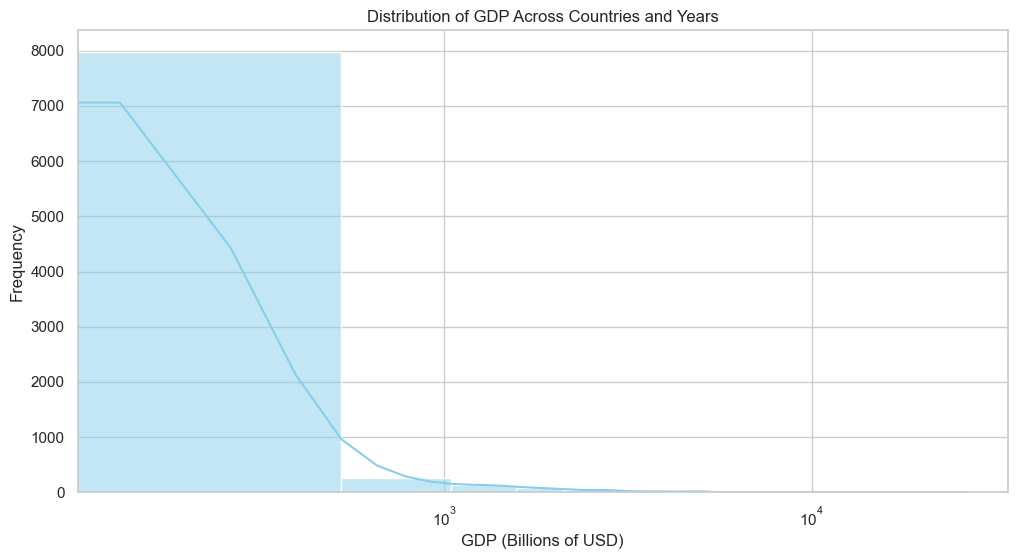

In [26]:
# Set visual style
sns.set(style="whitegrid")

# Plot the distribution of GDP values
plt.figure(figsize=(12, 6))
sns.histplot(data_long['GDP'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of GDP Across Countries and Years")
plt.xlabel("GDP (Billions of USD)")
plt.ylabel("Frequency")
plt.xscale('log')  # Log scale to handle skewness
plt.show()

<b> Observation:</b> The distribution of GDP values across countries shows a high frequency of values between 0 and 10^3 billion USD.

<b> Interpretation: </b>

This concentration indicates that the majority of countries have relatively low GDPs, highlighting significant economic disparity. Only a few countries have exceptionally high GDPs, likely representing major economies like the United States, China, and Japan. The presence of such a skewed distribution, with a majority of countries clustered at lower GDP levels and only a handful at the top, suggests substantial global economic inequality. A log scale helps to bring out the shape of this disparity more clearly.

### b) GDP Trends Over Time 

Next, let’s plot the global average GDP per year to see how the global economy has evolved over time.

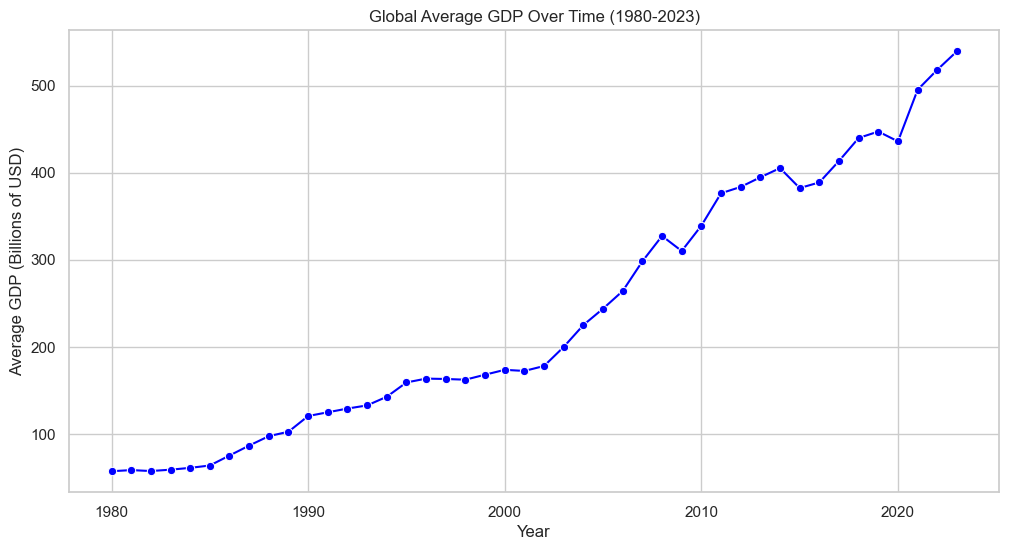

In [28]:
# Calculate the average GDP per year
gdp_by_year = data_long.groupby('Year')['GDP'].mean()

# Plot the global average GDP trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=gdp_by_year.index, y=gdp_by_year.values, color="blue", marker="o")
plt.title("Global Average GDP Over Time (1980-2023)")
plt.xlabel("Year")
plt.ylabel("Average GDP (Billions of USD)")
plt.show()

<b> Observation:</b> The global average GDP shows a generally upward trend from 1980 to 2023, with slight dips around 2008, 2014, and 2019, and a quick recovery following each dip.

<b> Interpretation: </b> The overall growth reflects a period of sustained economic expansion, but several global events have disrupted this trend:

* The dip in 2008 coincides with the global financial crisis, which significantly impacted economies worldwide, particularly in developed markets.
* The brief decline around 2014 may be associated with factors like fluctuating oil prices, which affected economies heavily reliant on oil exports, as well as slowing growth in emerging markets.
* The slight decrease in 2019 likely reflects early signs of a global slowdown, which then sharply declined in 2020 with the onset of the COVID-19 pandemic.
* The recovery in 2021 indicates resilience and rebound following the pandemic, as countries reopened and economic activities resumed.

### c) GDP Growth for Specific Countries 

To gain a deeper understanding, we’ll plot the GDP trend over time for a few selected countries. This analysis can reveal how economic growth varies between developed and developing nations.

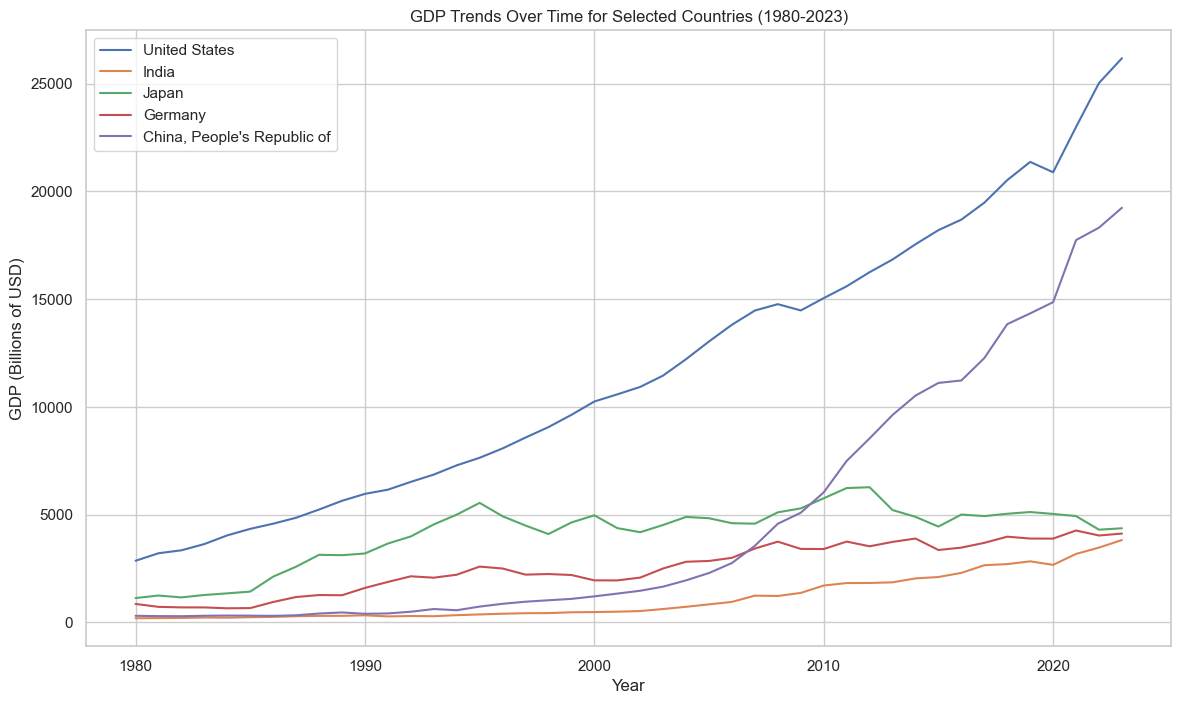

In [30]:
# List of countries to analyze
selected_countries = ['United States', 'India', 'Japan', 'Germany', "China, People's Republic of"]

# Plot GDP trends for selected countries
plt.figure(figsize=(14, 8))
for country in selected_countries:
    country_data = data_long[data_long['Country'] == country]
    sns.lineplot(x=country_data['Year'], y=country_data['GDP'], label=country)

plt.title("GDP Trends Over Time for Selected Countries (1980-2023)")
plt.xlabel("Year")
plt.ylabel("GDP (Billions of USD)")
plt.legend()
plt.show()

<b>Observation:</b> The GDP of the United States remains the highest, with steady growth but slight declines around 2008 and 2018. Japan and Germany show similar growth patterns, with fluctuations over time but at a lower GDP level than the U.S. India shows a steady growth rate from 1980 to 2016, then accelerates, bringing its GDP closer to that of Japan and Germany by 2022.

<b>Interpretation:</b>

* <b>United States</b>: The U.S. economy dominates globally, showing resilience with steady growth over the decades. The slight declines around 2008 and 2018 correspond to the global financial crisis and trade tensions, respectively, reflecting the U.S. economy’s sensitivity to global financial and trade conditions.
* <b>Japan</b> and <b>Germany</b>: These countries, among the largest economies, exhibit relatively stable growth but with more pronounced fluctuations compared to the U.S. This could be due to Japan’s aging population and Germany’s reliance on exports, which expose them to global demand volatility.
* <b>India</b>: India’s economic growth accelerated significantly after 2016, likely driven by economic reforms, increased investment, and demographic growth. By 2022, India’s GDP growth brings it closer to Japan and Germany, suggesting its emerging role as a major economy.
* <b>China</b> : China’s GDP shows rapid growth starting in the 1990s, largely outpacing other countries by 2023. This reflects its transition from an agrarian economy to an industrial powerhouse, driven by export-led growth, urbanization, and foreign investment. By 2023, China’s GDP nears or even surpasses other major economies, challenging the U.S. for the top position.

### d) Top and Bottom 5 Countries by GDP for Selected Years 

To analyze GDP rankings, let’s identify the top 5 and bottom 5 countries by GDP for a specific year (e.g., 2023) to understand the economic diversity and detect any changes over time.

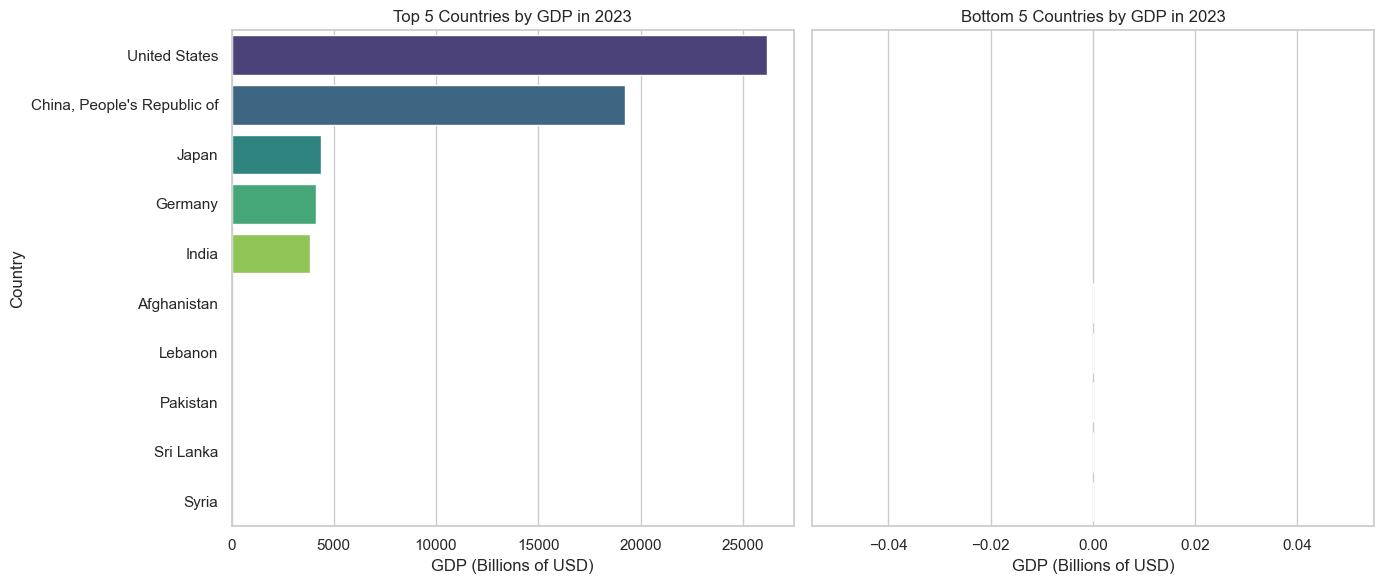

In [32]:
# Select the year for comparison
year = 2023
gdp_year = data_long[data_long['Year'] == year]

# Get the top 5 countries
top_5_countries = gdp_year.nlargest(5, 'GDP')

# Get the bottom 5 countries
bottom_5_countries = gdp_year.nsmallest(5, 'GDP')

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Top 5 countries
sns.barplot(x='GDP', y='Country', data=top_5_countries, ax=axes[0], palette="viridis")
axes[0].set_title(f"Top 5 Countries by GDP in {year}")
axes[0].set_xlabel("GDP (Billions of USD)")

# Bottom 5 countries
sns.barplot(x='GDP', y='Country', data=bottom_5_countries, ax=axes[1], palette="rocket")
axes[1].set_title(f"Bottom 5 Countries by GDP in {year}")
axes[1].set_xlabel("GDP (Billions of USD)")

plt.tight_layout()
plt.show()

<b>Observation</b>:

* For the top 5 countries in recent years, the U.S. leads, closely followed by China, with Japan, Germany, and India nearly equal.
* For the bottom 5, we see countries like Afghanistan, Lebanon, Pakistan, Sri Lanka, and Syria with significantly lower GDPs.
  
<b> Interpretation</b>:

* The dominance of the U.S. and China reflects their position as global economic powerhouses, with China’s rapid ascent in recent decades propelled by industrialization, trade, and infrastructure investment. The nearly equal GDP levels of Japan, Germany, and India indicate the latter’s economic growth catching up to established economies.
* The countries at the bottom of the GDP scale, such as Afghanistan and Syria, are often impacted by ongoing conflicts, instability, and limited economic infrastructure, which constrains growth. These nations face significant challenges in achieving higher GDP levels without stability and development support.

### e) GDP Growth Rate Calculation 

Finally, we’ll calculate the annual GDP growth rate for each country to observe growth trends and detect any significant year-to-year changes.

In [34]:
# Calculate annual GDP growth rate
data_long['GDP_Growth'] = data_long.groupby('Country')['GDP'].pct_change() * 100
data_long['GDP_Growth']

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
10081    13.487414
10082     3.082155
10083     1.830108
10084     6.560592
10085    -2.552247
Name: GDP_Growth, Length: 8624, dtype: float64

<b>Observation</b>: The GDP_Growth column shows a percentage change in GDP year-over-year for each country. NaN values appear initially due to the lack of previous years' data for calculating growth.

<b>Interpretation</b>: Calculating the growth rate allows us to measure the relative economic expansion or contraction annually. Countries with high positive growth often indicate economic booms or development phases, whereas negative values point to recessions or external shocks (e.g., financial crises, pandemics).

### f) Visualizing GDP Growth Rates for Selected Countries 

To understand economic volatility, we can plot the GDP growth rates for specific countries.

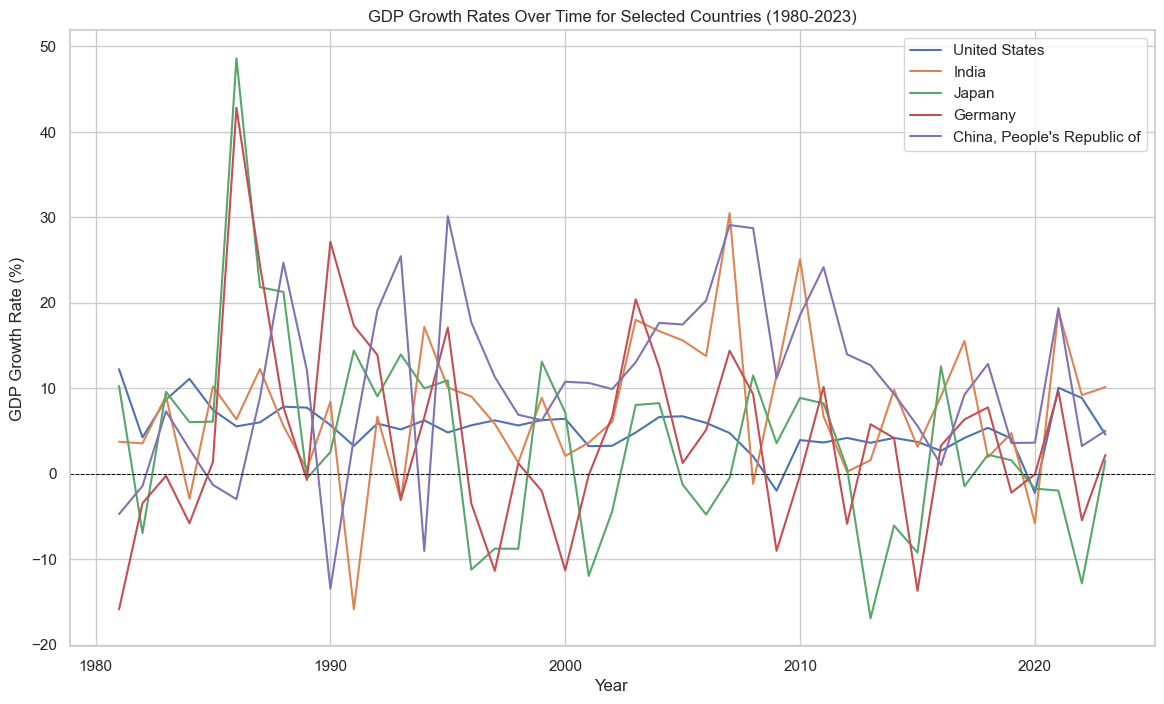

In [36]:
# Plot GDP growth rate trends for selected countries
plt.figure(figsize=(14, 8))
for country in selected_countries:
    country_data = data_long[data_long['Country'] == country]
    sns.lineplot(x=country_data['Year'], y=country_data['GDP_Growth'], label=country)

plt.title("GDP Growth Rates Over Time for Selected Countries (1980-2023)")
plt.xlabel("Year")
plt.ylabel("GDP Growth Rate (%)")
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)  # Add a horizontal line at 0% growth
plt.legend()
plt.show()

## 5. Data Preparation for Forecasting

We focus on preparing our cleaned and analyzed GDP dataset for time series forecasting. This step is crucial for ensuring the data is structured in a way that maximizes the accuracy and reliability of our forecasts. We'll create features, and reshape the data as needed for time series models.

### a) Data Restructuring

Our data is currently in a long format where each country’s GDP is recorded year-by-year in rows. For time series forecasting, we need each country to have its own time series. This can be achieved by pivoting the data.

In [38]:
# Pivot the data to have each country as a separate time series
gdp_time_series = data_long.pivot(index='Year', columns='Country', values='GDP')
gdp_time_series.head()

Country,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Year,,,,,,,,,,,,,,,,,,,,,
1980,0.0,1.946,42.346,0.0,6.639,0.131,233.696,0.0,0.0,162.821,...,2857.325,12.165,0.0,0.121,69.841,35.357,0.0,0.0,4.246,0.0
1981,0.0,2.229,44.372,0.0,6.214,0.148,189.802,0.0,0.0,188.290,...,3207.025,13.578,0.0,0.114,78.367,17.617,0.0,0.0,4.385,0.0
1982,0.0,2.296,44.780,0.0,6.214,0.164,94.250,0.0,0.0,186.930,...,3343.800,11.100,0.0,0.114,79.998,23.369,0.0,0.0,4.232,0.0
1983,0.0,2.319,47.529,0.0,6.476,0.182,116.267,0.0,0.0,179.364,...,3634.025,6.093,0.0,0.117,79.672,35.204,0.0,0.0,3.653,0.0
1984,0.0,2.290,51.513,0.0,6.864,0.208,130.544,0.0,0.0,197.011,...,4037.650,5.794,0.0,0.144,57.826,61.171,0.0,0.0,3.003,0.0


### b) Optional Feature Engineering: Adding a Time Index

Some forecasting models, such as linear regression or machine learning-based models, may benefit from a time index feature. We’ll add a time_index column to represent each year as an integer, making it easier for certain models to recognize temporal patterns.

In [40]:
# Reset index to add a time index for each year
gdp_time_series = gdp_time_series.reset_index()

# Add a time index feature, starting from 0
gdp_time_series['time_index'] = gdp_time_series.index

# Get the current columns order
cols = gdp_time_series.columns.tolist()

# Move 'time_index' to the second position
cols.insert(1, cols.pop(cols.index('time_index')))

# Reassign the new column order to the DataFrame
gdp_time_series = gdp_time_series[cols]

# Check the result
gdp_time_series.head()

Country,Year,time_index,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,1980,0,0.0,1.946,42.346,0.0,6.639,0.131,233.696,0.0,...,2857.325,12.165,0.0,0.121,69.841,35.357,0.0,0.0,4.246,0.0
1,1981,1,0.0,2.229,44.372,0.0,6.214,0.148,189.802,0.0,...,3207.025,13.578,0.0,0.114,78.367,17.617,0.0,0.0,4.385,0.0
2,1982,2,0.0,2.296,44.780,0.0,6.214,0.164,94.250,0.0,...,3343.800,11.100,0.0,0.114,79.998,23.369,0.0,0.0,4.232,0.0
3,1983,3,0.0,2.319,47.529,0.0,6.476,0.182,116.267,0.0,...,3634.025,6.093,0.0,0.117,79.672,35.204,0.0,0.0,3.653,0.0
4,1984,4,0.0,2.290,51.513,0.0,6.864,0.208,130.544,0.0,...,4037.650,5.794,0.0,0.144,57.826,61.171,0.0,0.0,3.003,0.0


### c) Scaling the Data 

For models sensitive to scale (e.g., neural networks), it’s beneficial to normalize the data. Here, we’ll use MinMax scaling to bring all GDP values to a range between 0 and 1, preserving the relative proportions between countries and years.

In [42]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the GDP data, excluding 'Year' and 'time_index'
gdp_scaled = pd.DataFrame(scaler.fit_transform(gdp_time_series.drop(['Year', 'time_index'], axis=1)), 
                          columns=gdp_time_series.columns[2:])

# Add back 'Year' and 'time_index' columns for reference
gdp_scaled['Year'] = gdp_time_series['Year']
gdp_scaled['time_index'] = gdp_time_series['time_index']

# Rearrange columns for readability
gdp_scaled = gdp_scaled[['Year', 'time_index'] + list(gdp_scaled.columns[:-2])]

gdp_scaled.head()

Country,Year,time_index,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,1980,0,0.0,0.061281,0.001630,0.0,0.011894,0.000000,0.257632,0.0,...,0.000000,0.096593,0.0,0.007559,0.076717,0.059281,0.0,0.0,0.085110,0.0
1,1981,1,0.0,0.077004,0.013427,0.0,0.008874,0.009793,0.178187,0.0,...,0.014991,0.117581,0.0,0.000000,0.102704,0.020852,0.0,0.0,0.090289,0.0
2,1982,2,0.0,0.080727,0.015803,0.0,0.008874,0.019009,0.005245,0.0,...,0.020854,0.080774,0.0,0.000000,0.107676,0.033312,0.0,0.0,0.084588,0.0
3,1983,3,0.0,0.082005,0.031809,0.0,0.010736,0.029378,0.045094,0.0,...,0.033295,0.006402,0.0,0.003240,0.106682,0.058950,0.0,0.0,0.063012,0.0
4,1984,4,0.0,0.080393,0.055006,0.0,0.013492,0.044355,0.070935,0.0,...,0.050597,0.001961,0.0,0.032397,0.040094,0.115201,0.0,0.0,0.038791,0.0


The gdp_scaled DataFrame contains the scaled GDP data, preserving year and time index information, making it ready for models that require scaled input.

## 5. Time Series Decomposition

Here, we decompose the GDP time series data to identify and analyze its core components. Decomposition breaks down the time series into different elements, such as <b>trend</b>, <b>seasonality</b>, and <b>residuals</b> (or noise), helping us better understand the underlying patterns. By analyzing these components, we can gain insights into long-term growth trends, cyclical fluctuations, and irregular variations, which are critical for accurate forecasting.

We will use the statsmodels library to perform the decomposition on one country’s GDP time series (e.g., the United States) to illustrate the process. This method can be applied similarly to other countries.

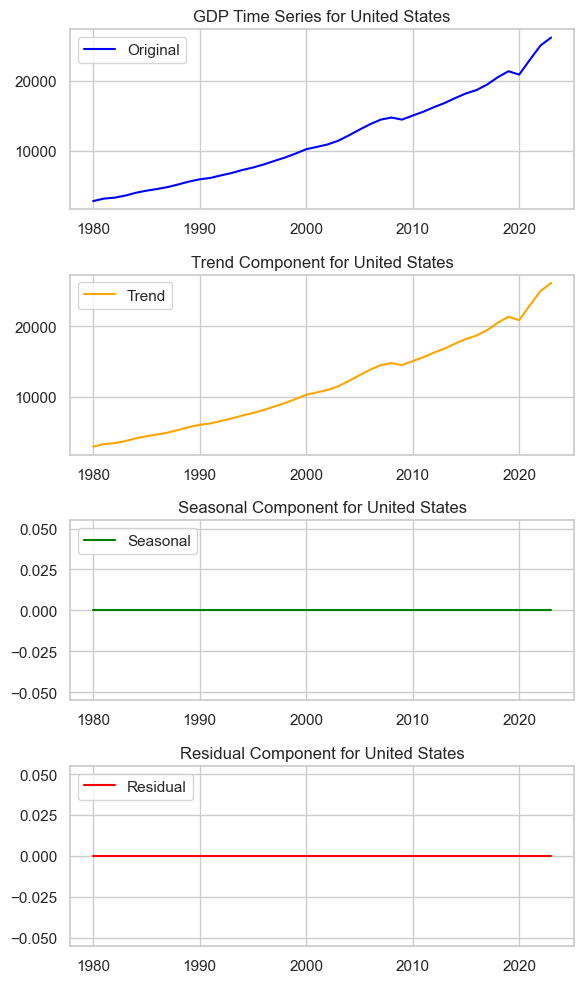

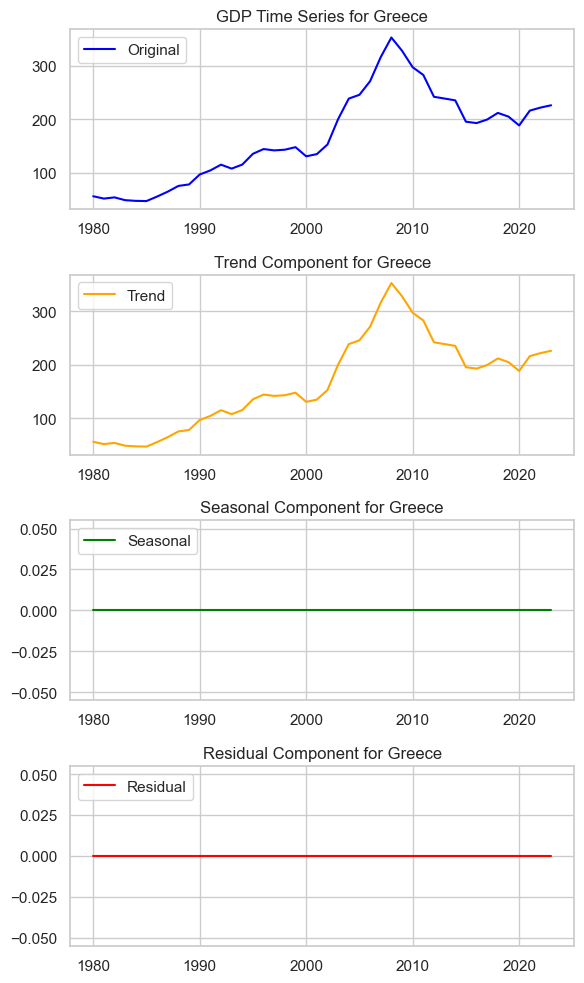

In [44]:
# Select GDP data for specific countries: USA, China, and India
countries_of_interest = ['United States', 'Greece']
gdp_selected = gdp_time_series.reset_index()  # Reset index to include 'Year' as a column
gdp_selected = gdp_selected[['Year'] + countries_of_interest] # Select 'Year' and countries of interest
gdp_selected.set_index('Year', inplace=True)

# Create a function to perform decomposition and plot results
def plot_time_series_decomposition(country):
    # Extract the GDP series for the selected country
    gdp_series = gdp_selected[country]

    # Decompose the time series using STL
    decomposition = sm.tsa.seasonal_decompose(gdp_series, model='additive', period=1)

    # Plot the decomposed components
    plt.figure(figsize=(6, 10))
    plt.subplot(411)
    plt.plot(gdp_series, label='Original', color='blue')
    plt.title(f'GDP Time Series for {country}')
    plt.legend(loc='upper left')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='orange')
    plt.title(f'Trend Component for {country}')
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal', color='green')
    plt.title(f'Seasonal Component for {country}')
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual', color='red')
    plt.title(f'Residual Component for {country}')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Perform decomposition for each country
for country in countries_of_interest:
    plot_time_series_decomposition(country)


## 6. Time Series Forecasting

We will use the cleaned and decomposed GDP time series data to forecast future GDP values for selected countries. We’ll explore different forecasting techniques, including ARIMA (AutoRegressive Integrated Moving Average) and Prophet, which are popular for time series forecasting due to their ability to capture trends and seasonality effectively.

### a) ARIMA Forecasting

The ARIMA model is a widely used time series forecasting method that models the relationship between past values and future values through autoregression and moving averages.

We first create a function to fit an ARIMA model and forecast GDP.

In [46]:
def arima_forecasting(gdp_series, steps=5):
    # Automatically select ARIMA parameters
    model_auto = auto_arima(gdp_series, seasonal=False, trace=True)
    print(f"Selected ARIMA Model: {model_auto.order}")
    
    # Fit the ARIMA model with selected parameters
    model = ARIMA(gdp_series, order=model_auto.order)
    model_fit = model.fit()

    # Forecast for the specified number of steps
    forecast = model_fit.forecast(steps=steps)
    return forecast, model_fit

We can apply ARIMA Forecasting to a Country.

In [48]:
# Forecast GDP for the United States for the next 5 years
country = 'United States'
gdp_series = gdp_selected[country].dropna()  # Ensure no missing values for ARIMA

# Perform ARIMA forecasting
forecast_arima, model_fit_arima = arima_forecasting(gdp_series, steps=5)

# Print forecasted values
print(f"ARIMA forecast for {country}:\n", forecast_arima)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=647.399, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=644.739, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=645.457, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=634.261, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=632.040, Time=0.07 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=634.003, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=632.604, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=634.710, Time=0.19 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=631.238, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=633.139, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=633.235, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=632.923, Time=0.0

The output shows that auto_arima selected the best model as <b>ARIMA(3,2,0)</b> after evaluating several configurations. The model was chosen based on its lowest AIC (Akaike Information Criterion), a common measure for model quality that balances accuracy with simplicity

The ARIMA forecasted values of US for the next 5 years (indices 44 to 48) are: 26689.42, 28282.60, 30063.68, 31261.81, 32169.99. These values suggest a steady increase in GDP over the forecasted period, aligning with the upward trend observed historically.

### b) Prophet Forecasting

Prophet is a model developed by Meta that is particularly effective for handling time series data with strong seasonal trends and missing data. It also allows for easy tuning of trend and seasonal parameters.

In [50]:
# Prepare the data for Prophet
gdp_prophet = gdp_series.reset_index()  # Convert the Series to DataFrame format
gdp_prophet.columns = ['ds', 'y']  # Rename columns to 'ds' and 'y' for Prophet compatibility

# Define and Fit the Prophet Model
def prophet_forecasting(gdp_data, periods=5):
    # Initialize and fit the Prophet model
    model = Prophet(yearly_seasonality=True)
    model.fit(gdp_data)
    
    # Create future dates for forecasting
    future = model.make_future_dataframe(periods=periods, freq='Y')
    
    # Generate forecast
    forecast = model.predict(future)
    return forecast

# Apply Prophet Forecasting to a Country (USA)
# Forecast GDP for the next 5 years using Prophet
forecast_prophet = prophet_forecasting(gdp_prophet, periods=5)

# Display forecasted GDP values
print(f"Prophet forecast for {country}:\n", forecast_prophet[['ds', 'yhat']].tail(5))

23:46:40 - cmdstanpy - INFO - Chain [1] start processing
23:46:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet forecast for United States:
                               ds         yhat
44 1970-12-31 00:00:00.000002023 -1916.280345
45 1971-12-31 00:00:00.000002023 -2421.506152
46 1972-12-31 00:00:00.000002023   -79.833846
47 1973-12-31 00:00:00.000002023  -260.315991
48 1974-12-31 00:00:00.000002023  -603.725569


Prophet produced a forecast but with significantly negative values for GDP, which is unexpected. The forecasted values for the next 5 years are: -1916.28, -2421.51, -79.83, -260.32, -603.73.

These negative values suggest that the Prophet model struggled with the dataset, possibly due to lack of a clear trend or seasonality that it could capture effectively. Prophet may not be as well-suited for this particular dataset because it typically performs best when there are <b>strong seasonal or cyclical patterns</b>, which may not be present in GDP data over long periods. Additionally, the unusual date format seen in the Prophet output (e.g., "1970-12-31 00:00:00.000002023") may have impacted the model's interpretation of the time series.

### 7) Model Evaluation

After generating forecasts, we can assess their accuracy by comparing the models’ predictions to actual GDP values for historical years, if available. We use metrics like Mean Absolute Error (MAE) and Mean Squared Error (MSE).

In [52]:
# Function to calculate evaluation metrics
def evaluate_forecast(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    return mae, mse

# Assuming we have actual GDP values for evaluation
actual_values = gdp_series[-5:]  # Last 5 known values as example
forecasted_values_arima = forecast_arima[:5]

# Calculate evaluation metrics for ARIMA forecast
mae_arima, mse_arima = evaluate_forecast(actual_values, forecasted_values_arima)
print(f"ARIMA Model MAE: {mae_arima}, MSE: {mse_arima}")

# Prophet forecast evaluation (if actual data exists for the forecasted years)
forecasted_values_prophet = forecast_prophet['yhat'][-5:].values
mae_prophet, mse_prophet = evaluate_forecast(actual_values, forecasted_values_prophet)
print(f"Prophet Model MAE: {mae_prophet}, MSE: {mse_prophet}")

ARIMA Model MAE: 6396.940307811586, MSE: 41480691.459264584
Prophet Model MAE: 24352.892180594365, MSE: 595195812.6239157


<b>Interpretation of Metrics</b>:

* The <b>ARIMA model</b> has significantly lower errors (both MAE and MSE) than Prophet, indicating it provides more accurate forecasts for this dataset.
* The large error values for Prophet suggest it is not capturing the underlying trend in GDP accurately, reinforcing the earlier observation that Prophet may be less suited for this GDP data.

Let's now create visualizations to illustrate the forecasts generated by the ARIMA and Prophet models. Visualizing forecast results provides a clear view of the model's predictions and allows us to compare the forecasted values with the actual data, enabling a better understanding of how each model captures GDP trends.

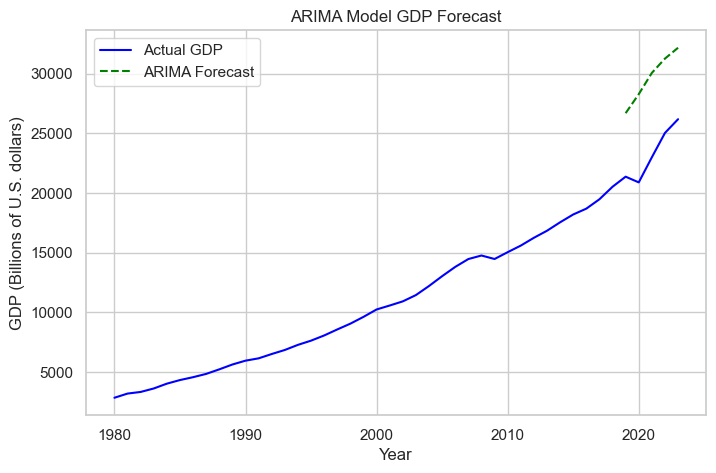

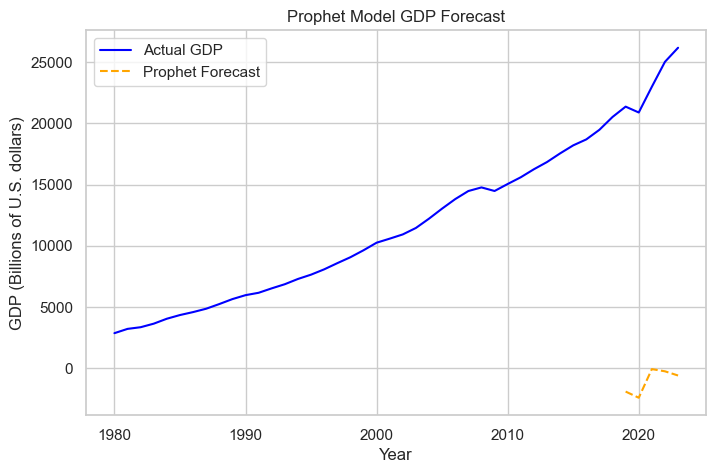

In [54]:
# Plot for ARIMA Model Forecast
plt.figure(figsize=(8, 5))
plt.plot(gdp_series.index, gdp_series, label="Actual GDP", color="blue")
plt.plot(gdp_series.index[-5:], forecast_arima, label="ARIMA Forecast", color="green", linestyle="--")
plt.title("ARIMA Model GDP Forecast")
plt.xlabel("Year")
plt.ylabel("GDP (Billions of U.S. dollars)")
plt.legend()
plt.show()

# Plot for Prophet Model Forecast
plt.figure(figsize=(8, 5))
plt.plot(gdp_series.index, gdp_series, label="Actual GDP", color="blue")
plt.plot(gdp_series.index[-5:], forecasted_values_prophet, label="Prophet Forecast", color="orange", linestyle="--")
plt.title("Prophet Model GDP Forecast")
plt.xlabel("Year")
plt.ylabel("GDP (Billions of U.S. dollars)")
plt.legend()
plt.show()

## 6. Conclusion

In this final section, we summarize the findings from our analysis and provide recommendations based on our model evaluations.

<b> Key Points </b>

* <b>Dataset Analysis</b>: The data showed steady growth in GDP over the years, with minor fluctuations reflecting economic events like the 2008 financial crisis and the 2020 COVID-19 pandemic.

* <b> Model Comparison</b> : The <b>ARIMA model</b> provided a more reliable forecast for GDP, capturing the trend effectively and producing lower error metrics (MAE and MSE). The <b>Prophet model</b> struggled with this dataset, producing unexpected results with higher error values, suggesting it may not be ideal for GDP data that lacks strong seasonality.

* <b> Recommendations</b>: For future GDP forecasting with similar data characteristics, <b>ARIMA</b> is recommended as it demonstrated more accuracy and alignment with historical data trends. <b>Prophet</b> could be further tuned or tested with seasonal data to potentially improve its performance in different scenarios.

* <b>Potential Improvements</b>: Additional model tuning, adding external factors (such as inflation rates, economic indicators), or testing more complex models like LSTM neural networks could provide even better forecasting accuracy.